In [3]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters
# autoreload may cause pickling errors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_result_by_name, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [5]:
dataset = 'adult'
learner_type = 'SVM'
loader_func = load_adult

In [6]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [7]:
X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [8]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Support Vector Machine Model Complexity
Sources:
1. https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
2. https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

#### Hyperparameters for SVMs

**Kernel:** The kernel function used to perform the "kernel trick"

**C:** Penalty parameter C of the error term. The regularization parameter. Can determine the resistance to outliers. Intuitively, this determines how hard the algorithm tries to find the largest margin. For larger values of C, the algorithm will try to fit all data points. For lower values of C, it will prefer the largest margin.

**gamma:** Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.

In [9]:
from sklearn.svm import LinearSVC

linear_clf = LinearSVC(random_state=1)

linear_param_grid = {
    'C': np.logspace(-3, 2, 6),
    'max_iter': np.logspace(1, 4, 4)
}
linear_param_grid

{'C': array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
          1.00000000e+00,   1.00000000e+01,   1.00000000e+02]),
 'max_iter': array([    10.,    100.,   1000.,  10000.])}

In [10]:
linear_grid_search = GridSearchCV(
    estimator=linear_clf,
    param_grid=linear_param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [11]:
linear_grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] C=0.001, max_iter=10.0 ..........................................
[CV] C=0.001, max_iter=100.0 .........................................
[CV] . C=0.001, max_iter=10.0, score=0.7116182118652363, total=   0.1s
[CV] C=0.001, max_iter=100.0 .........................................
[CV] . C=0.001, max_iter=10.0, score=0.7161683077683935, total=   0.1s
[CV] C=0.001, max_iter=100.0 .........................................
[CV] C=0.001, max_iter=100.0 .........................................
[CV] . C=0.001, max_iter=10.0, score=0.7010885258037712, total=   0.2s
[CV] . C=0.001, max_iter=10.0, score=0.7082866805818578, total=   0.1s
[CV] C=0.001, max_iter=1000.0 ........................................
[CV]  C=0.001, m

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.


[CV] C=0.001, max_iter=1000.0 ........................................
[CV]  C=0.001, max_iter=100.0, score=0.7161683077683935, total=   0.2s
[CV]  C=0.001, max_iter=100.0, score=0.7116182118652363, total=   0.2s
[CV]  C=0.001, max_iter=100.0, score=0.7082866805818578, total=   0.1s
[CV]  C=0.001, max_iter=1000.0, score=0.7116182118652363, total=   0.2s
[CV] C=0.001, max_iter=1000.0 ........................................
[CV] C=0.001, max_iter=10000.0 .......................................
[CV]  C=0.001, max_iter=1000.0, score=0.7161683077683935, total=   0.1s
[CV] C=0.001, max_iter=10000.0 .......................................
[CV]  C=0.001, max_iter=1000.0, score=0.7010885258037712, total=   0.2s
[CV] C=0.001, max_iter=10000.0 .......................................
[CV] C=0.001, max_iter=10000.0 .......................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s


[CV] C=0.01, max_iter=10.0 ...........................................
[CV]  C=0.001, max_iter=1000.0, score=0.7082866805818578, total=   0.2s
[CV]  C=0.001, max_iter=10000.0, score=0.7116182118652363, total=   0.1s
[CV] C=0.01, max_iter=10.0 ...........................................
[CV]  C=0.001, max_iter=10000.0, score=0.7010885258037712, total=   0.2s
[CV]  C=0.001, max_iter=10000.0, score=0.7161683077683935, total=   0.1s
[CV] C=0.01, max_iter=10.0 ...........................................
[CV] C=0.01, max_iter=10.0 ...........................................
[CV] .. C=0.01, max_iter=10.0, score=0.7432320667330772, total=   0.2s
[CV] .. C=0.01, max_iter=10.0, score=0.7380325133200325, total=   0.1s
[CV] C=0.01, max_iter=100.0 ..........................................
[CV]  C=0.001, max_iter=10000.0, score=0.7082866805818578, total=   0.2s
[CV] .. C=0.01, max_iter=10.0, score=0.7434732224725729, total=   0.1s
[CV] C=0.01, max_iter=100.0 ........................................

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s


[CV] C=0.01, max_iter=1000.0 .........................................
[CV] . C=0.01, max_iter=100.0, score=0.7380325133200325, total=   0.2s
[CV]  C=0.01, max_iter=1000.0, score=0.7432320667330772, total=   0.1s
[CV] C=0.01, max_iter=1000.0 .........................................
[CV] . C=0.01, max_iter=100.0, score=0.7434732224725729, total=   0.2s
[CV] . C=0.01, max_iter=100.0, score=0.7420646165566199, total=   0.2s
[CV] C=0.01, max_iter=10000.0 ........................................
[CV]  C=0.01, max_iter=1000.0, score=0.7380325133200325, total=   0.3s
[CV]  C=0.01, max_iter=1000.0, score=0.7434732224725729, total=   0.2s
[CV]  C=0.01, max_iter=1000.0, score=0.7420646165566199, total=   0.2s
[CV] C=0.01, max_iter=10000.0 ........................................
[CV] C=0.01, max_iter=10000.0 ........................................
[CV] C=0.01, max_iter=10000.0 ........................................
[CV]  C=0.01, max_iter=10000.0, score=0.7432320667330772, total=   0.2s
[CV] 

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.6s


[CV] C=0.1, max_iter=100.0 ...........................................
[CV] C=0.1, max_iter=1000.0 ..........................................
[CV] ... C=0.1, max_iter=10.0, score=0.7675719604292515, total=   0.2s
[CV] C=0.1, max_iter=10.0 ............................................
[CV] C=0.1, max_iter=1000.0 ..........................................
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] ... C=0.1, max_iter=10.0, score=0.7700297732868264, total=   0.1s
[CV] .. C=0.1, max_iter=100.0, score=0.7561762837307414, total=   0.2s
[CV] C=0.1, max_iter=100.0 ...........................................
[CV] C=0.1, max_iter=10000.0 .........................................
[CV] .. C=0.1, max_iter=100.0, score=0.7631234381887521, total=   0.2s
[CV] C=0.1, max_iter=100.0 ...........................................
[CV] C=1.0, max_iter=10.0 ............................................
[CV] . C=0.1, max_iter=1000.0, score=0.7631234381887521, total=   0.2s
[CV] .

[CV]  C=10.0, max_iter=10000.0, score=0.7633672612108674, total=   2.1s
[CV]  C=100.0, max_iter=10000.0, score=0.7570612148537141, total=  11.0s
[CV] C=100.0, max_iter=10000.0 .......................................
[CV]  C=100.0, max_iter=10000.0, score=0.7660477785610832, total=  11.0s
[CV] C=100.0, max_iter=10000.0 .......................................
[CV]  C=100.0, max_iter=10000.0, score=0.762477979133357, total=   8.8s
[CV]  C=100.0, max_iter=10000.0, score=0.7630099740894842, total=   9.3s


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   24.3s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'max_iter': array([   10.,   100.,  1000., 10000.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=10)

In [12]:
save_search_result(linear_grid_search, dataset, learner_type, extras='linear')

In [10]:
from sklearn.svm import SVC

rbf_clf = SVC(kernel='rbf', random_state=1)

rbf_param_grid = {
    'C': np.logspace(-3, 2, 6),
    'max_iter': np.logspace(1, 4, 4),
    'gamma': np.logspace(-4, 1, 6),
}
rbf_param_grid

{'C': array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
          1.00000000e+00,   1.00000000e+01,   1.00000000e+02]),
 'max_iter': array([    10.,    100.,   1000.,  10000.]),
 'gamma': array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
          1.00000000e-01,   1.00000000e+00,   1.00000000e+01])}

In [14]:
rbf_grid_search = GridSearchCV(
    estimator=rbf_clf,
    param_grid=rbf_param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=-1,
)

In [15]:
rbf_grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=10.0 ............................
[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................
[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.0001, max_iter=100.0 ...........................
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.2s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.5428792542317693, total=   0.2s
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.2s
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=0.001, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.2s
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=1000.0 ..........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.0001, max_iter=10000.0 .........................
[CV] C=0.001, gamma=0.001, max_iter=10.0 .............................
[CV] C=0.001, gamma=0.001, max_iter=10.0 .............................
[CV] C=0.001, gamma=0.001, max_iter=10.0

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.49432161139755526, total=   0.3s
[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.6099211779685357, total=   0.3s
[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=10.0, score=0.7106461962840603, total=   0.3s
[CV] C=0.001, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7131490150690689, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7017750699983258, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.6880791276741818, total=   1.3s
[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=100.0, score=0.7090444518167311, total=   1.3s


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s


[CV] C=0.001, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.6616052560359769, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.6076981647613913, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7077598692647833, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.001, max_iter=100.0, score=0.7202810453902474, total=   1.2s
[CV] C=0.001, gamma=0.001, max_iter=10000.0 ..........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.707173018861768, total=  14.2s
[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6330530712485428, total=  14.3s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.4s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.6860884182912574, total=  14.4s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.43240713549494136, total=   0.2s
[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.7236531215870985, total=  12.9s
[CV] C=0.001, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.5657377585483967, total=   0.2s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.6917397367786486, total=  12.9s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.5193656915281675, total=   0.2s
[CV] C=0.001, gamma=0.01, max_iter=100.0 .............................
[CV]  C=0.001, gamma=0.0001, max_iter=1000.0, score=0.7467567698326031, total=  14.7s
[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.5891770224255745, total=  13.0s
[CV]  C=0.001, gamma=0.01, max_iter=10.0, score=0.6618986786712067, total=   0.2s
[CV]  C=0.001, gamma=0.001, max_iter=1000.0, score=0.5469871921878335, total=  13.0s
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................
[CV] C=0.001, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.6423455041353088, total=   1.5s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.546432158835916, total=   1.5s
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.6407962760737045, total=   1.4s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=0.01, max_iter=100.0, score=0.6361022029314055, total=   1.4s
[CV] C=0.001, gamma=0.01, max_iter=10000.0 ...........................


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.9s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated 

[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.6599460461688172, total=  13.4s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.6436357583548742, total=  13.3s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.7061053284737676, total=  13.5s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=0.001, gamma=0.01, max_iter=1000.0, score=0.6538337042515056, total=  13.6s
[CV] C=0.001, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.5372529035452905, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.6708640703930504, total=   0.3s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.6830101046403937, total=   0.3s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=0.001, gamma=0.1, max_iter=10.0, score=0.7561472199567799, total=   0.3s
[CV] C=0.001, gamma=0.1, max_iter=100.0 ..............................


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.0s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated ear

[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.6372704658916201, total=   1.4s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.72980646211643, total=   1.4s
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.4646205115445401, total=   1.4s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.1, max_iter=100.0, score=0.7563973785377377, total=   1.4s
[CV] C=0.001, gamma=0.1, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.7359291077843668, total=  13.4s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.6879371632684006, total=  13.6s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.7504120033113855, total=  13.3s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.1, max_iter=1000.0, score=0.7573615354015668, total=  13.6s
[CV] C=0.001, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.4999999999999999, total=  51.8s
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.501909209387314, total=   0.3s
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.5022852168757785, total=   0.3s
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.503174498953289, total=   0.3s
[CV] C=0.001, gamma=1.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.5, total=  52.8s
[CV]  C=0.001, gamma=1.0, max_iter=10.0, score=0.506986009550183, total=   0.3s
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min


[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.5, total=  53.4s
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=0.001, max_iter=10000.0, score=0.5, total=  54.0s
[CV] C=0.001, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5304723023564253, total=   1.5s
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5889888755266193, total=   1.5s
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.575912474062606, total=   1.5s
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=1.0, max_iter=100.0, score=0.5077639393813731, total=   1.3s
[CV] C=0.001, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.5, total=  58.8s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.5, total=  59.4s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.4999999999999999, total=  59.4s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=0.001, gamma=0.0001, max_iter=10000.0, score=0.5, total=  59.9s
[CV] C=0.001, gamma=1.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.6396336050328143, total=  14.0s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.582554352102971, total=  14.2s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.8min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.5006393461816772, total=   0.3s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.5006348997906579, total=   0.3s
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.7185992424975465, total=  14.1s
[CV] C=0.001, gamma=10.0, max_iter=10.0 ..............................
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................
[CV] . C=0.001, gamma=0.01, max_iter=10000.0, score=0.5, total=  56.3s
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.5016503170851208, total=   0.3s
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................
[CV]  C=0.001, gamma=10.0, max_iter=10.0, score=0.5048248160384097, total=   0.3s
[CV] C=0.001, gamma=10.0, max_iter=100.0 .............................
[CV]  C=0.001, gamma=1.0, max_iter=1000.0, score=0.7035638094448208, total=  13.9s
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV] . C=0.001, gamma=0.01, max_iter=10000.0, score=0.5, total=  57.8s
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] . C=0.001, gamma=0.01, max_iter=10000.0, score=0.5, total=  57.8s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=0.01, max_iter=10000.0, score=0.4999999999999999, total=  59.0s
[CV] C=0.001, gamma=10.0, max_iter=1000.0 ............................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.4999977927105705, total=   1.5s
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.4983475710619318, total=   1.5s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.5237456745411904, total=   1.4s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=10.0, max_iter=100.0, score=0.5099103499225143, total=   1.4s
[CV] C=0.001, gamma=10.0, max_iter=10000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.6246833499359885, total=  14.2s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.2min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.61401702076681, total=  13.7s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.3s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.5428792542317693, total=   0.3s
[CV] C=0.01, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.6223087313984152, total=  14.0s
[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.3s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.3s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................
[CV]  C=0.001, gamma=10.0, max_iter=1000.0, score=0.5022022786509328, total=  13.9s
[CV] C=0.01, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.6800718232786501, total=   1.4s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.7017750699983258, total=   1.4s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.6880791276741818, total=   1.4s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=0.01, gamma=0.0001, max_iter=100.0, score=0.7090444518167311, total=   1.4s
[CV] C=0.01, gamma=0.0001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV] .. C=0.001, gamma=0.1, max_iter=10000.0, score=0.5, total= 1.0min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.001, gamma=0.1, max_iter=10000.0, score=0.4999999999999999, total= 1.0min
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6289069502745676, total=  13.5s
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.7398995833122148, total=  13.5s
[CV] C=0.01, gamma=0.0001, max_iter=10000.0 ..........................
[CV] .. C=0.001, gamma=0.1, max_iter=10000.0, score=0.5, total= 1.0min
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.5min


[CV] .. C=0.001, gamma=0.1, max_iter=10000.0, score=0.5, total= 1.0min
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s
[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6450021272118779, total=  13.6s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.01, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=0.01, gamma=0.0001, max_iter=1000.0, score=0.6787245790501115, total=  13.7s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................
[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.49432161139755526, total=   0.3s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.6099211779685357, total=   0.3s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................
[CV]  C=0.01, gamma=0.001, max_iter=10.0, score=0.7106461962840603, total=   0.3s
[CV] C=0.01, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.6616052560359769, total=   1.5s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.6076981647613913, total=   1.5s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7077598692647833, total=   1.5s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=0.01, gamma=0.001, max_iter=100.0, score=0.7202810453902474, total=   1.4s
[CV] C=0.01, gamma=0.001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.6644968051884736, total=  14.0s
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=0.001, gamma=1.0, max_iter=10000.0, score=0.4999999999999999, total=  56.3s
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.7228001019832987, total=  14.0s
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.5891770224255745, total=  14.0s
[CV]  C=0.01, gamma=0.001, max_iter=1000.0, score=0.589610336253066, total=  14.2s
[CV] C=0.01, gamma=0.001, max_iter=10000.0 ...........................
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  2.9min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.43240713549494136, total=   0.3s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.5657377585483967, total=   0.3s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.5193656915281675, total=   0.3s
[CV] C=0.01, gamma=0.01, max_iter=10.0 ...............................
[CV] .. C=0.001, gamma=1.0, max_iter=10000.0, score=0.5, total=  56.6s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=10.0, score=0.6618986786712067, total=   0.3s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................
[CV] .. C=0.001, gamma=1.0, max_iter=10000.0, score=0.5, total=  57.2s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .. C=0.001, gamma=1.0, max_iter=10000.0, score=0.5, total=  57.3s
[CV] C=0.01, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.6538305108819369, total=   1.5s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.546432158835916, total=   1.5s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.6407962760737045, total=   1.5s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=100.0, score=0.6361022029314055, total=   1.3s
[CV] C=0.01, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.001, gamma=10.0, max_iter=10000.0, score=0.4999999999999999, total=  57.8s
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.6940648866316954, total=  13.7s
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV] . C=0.001, gamma=10.0, max_iter=10000.0, score=0.5, total=  57.9s
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.7178718051504638, total=  13.8s
[CV] C=0.01, gamma=0.01, max_iter=10000.0 ............................
[CV] . C=0.001, gamma=10.0, max_iter=10000.0, score=0.5, total=  58.2s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................
[CV] . C=0.001, gamma=10.0, max_iter=10000.0, score=0.5, total=  58.2s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.5898119222162322, total=  14.0s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................
[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.5372529035452905, total=   0.3s
[CV] C=0.01, gamma=0.1, max_iter=10.0 ................................


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.3min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.6708640703930504, total=   0.3s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.6830101046403937, total=   0.3s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, max_iter=10.0, score=0.7561472199567799, total=   0.3s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.01, max_iter=1000.0, score=0.6676457984877597, total=  14.0s
[CV] C=0.01, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.6568760904489626, total=   1.4s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.72980646211643, total=   1.5s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.4768260616476753, total=   1.5s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=100.0, score=0.7563973785377377, total=   1.5s
[CV] C=0.01, gamma=0.1, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.7581704257765339, total=  14.0s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.7378675968034994, total=  13.9s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.7323856105251678, total=  13.8s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.1, max_iter=1000.0, score=0.642628404498938, total=  13.9s
[CV] C=0.01, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.4999999999999999, total=  55.4s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.501909209387314, total=   0.3s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.5022852168757785, total=   0.3s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.503174498953289, total=   0.3s
[CV] C=0.01, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10.0, score=0.506986009550183, total=   0.3s
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.5, total=  56.1s
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................


[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  4.0min


[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.5, total=  55.5s
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=0.0001, max_iter=10000.0, score=0.5, total=  56.0s
[CV] C=0.01, gamma=1.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5304723023564253, total=   1.5s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5889888755266193, total=   1.5s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.575912474062606, total=   1.5s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=0.01, gamma=1.0, max_iter=100.0, score=0.5066223868699575, total=   1.4s
[CV] C=0.01, gamma=1.0, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.5651898940693012, total=  13.6s
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.4986002254691001, total=  13.6s
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.5872335417540205, total=  13.7s
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=0.01, gamma=1.0, max_iter=1000.0, score=0.6791029847009693, total=  13.8s
[CV] C=0.01, gamma=1.0, max_iter=10000.0 .............................
[CV] . C=0.01, gamma=0.001, max_iter=10000.0, score=0.5, total=  55.9s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................
[CV] . C=0.01, gamma=0.001, max_iter=10000.0, score=0.5, total=  56.4s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.5006393461816772, total=   0.3s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.5006348997906579, total=   0.3s
[CV] C=0.01, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.5016503170851208, total=   0.3s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10.0, score=0.5048248160384097, total=   0.3s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................
[CV]  C=0.01, gamma=0.001, max_iter=10000.0, score=0.4999999999999999, total=  58.2s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................
[CV] . C=0.01, gamma=0.001, max_iter=10000.0, score=0.5, total=  57.8s
[CV] C=0.01, gamma=10.0, max_iter=100.0 ..............................


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.4min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.4999977927105705, total=   1.5s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.4983475710619318, total=   1.5s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.5237456745411904, total=   1.5s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=0.01, gamma=10.0, max_iter=100.0, score=0.5099103499225143, total=   1.5s
[CV] C=0.01, gamma=10.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.6246833499359885, total=  14.0s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.6267107928740706, total=  14.1s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.6223087313984152, total=  14.2s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=10.0, max_iter=1000.0, score=0.5020761434339804, total=  14.2s
[CV] C=0.01, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=0.01, gamma=0.01, max_iter=10000.0, score=0.4999999999999999, total=  58.5s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.3s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.5428792542317693, total=   0.3s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.3s
[CV] C=0.1, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.3s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................
[CV] .. C=0.01, gamma=0.01, max_iter=10000.0, score=0.5, total=  59.6s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................
[CV] .. C=0.01, gamma=0.01, max_iter=10000.0, score=0.5, total=  59.2s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................
[CV] .. C=0.01, gamma=0.01, max_iter=10000.0, score=0.5, total=  59.8s
[CV] C=0.1, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.6598378889867773, total=   1.5s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.7017750699983258, total=   1.4s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.6980459216663825, total=   1.5s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=0.1, gamma=0.0001, max_iter=100.0, score=0.7090444518167311, total=   1.4s
[CV] C=0.1, gamma=0.0001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6373142145366134, total=  13.3s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6218029331997443, total=  13.5s
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.5697374160442461, total=  13.4s
[CV]  C=0.1, gamma=0.0001, max_iter=1000.0, score=0.6381084632314883, total=  13.2s


[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  5.2min


[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV] C=0.1, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.6014121853892794, total= 1.0min
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.6159950590320495, total= 1.0min


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.6138296418143813, total= 1.0min
[CV] C=0.1, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.49432161139755526, total=   0.3s
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.6099211779685357, total=   0.3s
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=0.1, gamma=0.001, max_iter=10.0, score=0.7106461962840603, total=   0.3s
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=0.01, gamma=0.1, max_iter=10000.0, score=0.6131989657296184, total= 1.0min
[CV] C=0.1, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.6616052560359769, total=   1.4s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.6076981647613913, total=   1.4s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.7077598692647833, total=   1.4s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=0.1, gamma=0.001, max_iter=100.0, score=0.7202810453902474, total=   1.3s
[CV] C=0.1, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.7228001019832987, total=  12.8s
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.6644968051884736, total=  12.9s
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.5644925332559242, total=  12.9s
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=0.1, gamma=0.001, max_iter=1000.0, score=0.6018850015435724, total=  12.9s
[CV] C=0.1, gamma=0.001, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.5428988619983455, total= 1.4min
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.43240713549494136, total=   0.3s
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................


[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  6.4min


[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.5408584029476858, total= 1.4min
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.5657377585483967, total=   0.4s
[CV] C=0.1, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.542006291017944, total= 1.5min
[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.5193656915281675, total=   0.3s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=10.0, score=0.6618986786712067, total=   0.3s
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=0.01, gamma=1.0, max_iter=10000.0, score=0.5411191207933809, total= 1.5min
[CV] C=0.1, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.5414846612578479, total=   1.5s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.5324839460778668, total=   1.5s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.6407962760737045, total=   1.5s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=100.0, score=0.6361022029314055, total=   1.5s
[CV] C=0.1, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=0.0001, max_iter=10000.0, score=0.4999999999999999, total=  56.0s
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................
[CV] . C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5, total=  56.1s
[CV] C=0.1, gamma=0.01, max_iter=10000.0 .............................
[CV] . C=0.1, gamma=0.0001, max_iter=10000.0, score=0.5, total=  56.3s
[CV] C=0.1, gamma=0.01,

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.6300462954965537, total=  14.1s
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................
[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.7190033743570368, total=  14.2s
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.6547287459279635, total=  14.2s
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.5372529035452905, total=   0.3s
[CV] C=0.1, gamma=0.1, max_iter=10.0 .................................
[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.6708640703930504, total=   0.3s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.6830101046403937, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.01, max_iter=1000.0, score=0.6264665858786921, total=  14.3s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=10.0, score=0.7561472199567799, total=   0.3s
[CV] C=0.1, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.632334966727511, total=   1.6s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.72980646211643, total=   1.5s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................


[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  6.9min


[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.7563973785377377, total=   1.5s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=100.0, score=0.7212033491683908, total=   1.5s
[CV] C=0.1, gamma=0.1, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV] .. C=0.1, gamma=0.001, max_iter=10000.0, score=0.5, total= 1.0min
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=0.001, max_iter=10000.0, score=0.4999999999999999, total= 1.1min
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV] .. C=0.1, gamma=0.001, max_iter=10000.0, score=0.5, total= 1.0min
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV] .. C=0.1, gamma=0.001, max_iter=10000.0, score=0.5, total= 1.1min
[CV] C=0.1, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5031724507246627, total= 1.7min
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.501909209387314, total=   0.3s
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.5022852168757785, total=   0.3s
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.503174498953289, total=   0.3s
[CV] C=0.1, gamma=1.0, max_iter=10.0 .................................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5019025875190259, total= 1.7min
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.7551776874672663, total=  14.1s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=1.0, max_iter=10.0, score=0.506986009550183, total=   0.3s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.7188305863886086, total=  14.0s
[CV] C=0.1, gamma=1.0, max_iter=100.0 ................................
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.7500581572780091, total=  14.3s
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=0.1, gamma=0.1, max_iter=1000.0, score=0.743252821819511, total=  14.1s
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5029201166664363, total= 1.7min
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=10.0, max_iter=10000.0, score=0.5019025875190259, total= 1.7min
[CV] C=0.1, gamma=1.0, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5304723023564253, total=   1.4s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5889888755266193, total=   1.4s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.575912474062606, total=   1.5s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=1.0, max_iter=100.0, score=0.5066223868699575, total=   1.4s
[CV] C=0.1, gamma=1.0, max_iter=10000.0 ..............................


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  7.2min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated 

[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.5764439991477942, total=  13.5s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.6715786446358167, total=  13.7s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................
[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.5006393461816772, total=   0.3s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................
[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.6689551473151822, total=  13.7s
[CV] C=0.1, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.5006348997906579, total=   0.3s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.5016503170851208, total=   0.3s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1.0, max_iter=1000.0, score=0.571497741469266, total=  13.4s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=10.0, max_iter=10.0, score=0.5048248160384097, total=   0.3s
[CV] C=0.1, gamma=10.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.4999977927105705, total=   1.6s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.4983475710619318, total=   1.6s
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.5399796801349129, total=   1.6s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=100.0, score=0.4975759767895841, total=   1.5s
[CV] C=0.1, gamma=10.0, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.5920520222335878, total=  14.1s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.5974193924928619, total=  14.2s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.495445309152233, total=  14.2s
[CV]  C=0.1, gamma=10.0, max_iter=1000.0, score=0.6168009274454367, total=  14.5s
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV] C=0.1, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.6770715741521487, total=  57.3s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.6784602140878807, total=  58.4s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.3s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.5428792542317693, total=   0.3s
[CV] C=1.0, gamma=0.0001, max_iter=10.0 ..............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.6858044700631406, total=  57.1s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.3s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.3s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................
[CV]  C=0.1, gamma=0.01, max_iter=10000.0, score=0.6809859895835734, total=  58.3s
[CV] C=1.0, gamma=0.0001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.6536477857048258, total=   1.4s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................


[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  8.1min


[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7017750699983258, total=   1.4s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.6980459216663825, total=   1.4s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................
[CV]  C=1.0, gamma=0.0001, max_iter=100.0, score=0.7090444518167311, total=   1.4s
[CV] C=1.0, gamma=0.0001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.7127663862449399, total=  48.4s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.7164290256140885, total=  47.5s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.7012167728736713, total=  49.4s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=0.1, gamma=0.1, max_iter=10000.0, score=0.7076665637618321, total=  49.5s
[CV] C=1.0, gamma=0.0001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.7199889251652106, total=  12.8s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.5697374160442461, total=  12.9s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................
[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.49432161139755526, total=   0.3s
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.6768995541302467, total=  13.1s
[CV] C=1.0, gamma=0.001, max_iter=10.0 ...............................
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=0.0001, max_iter=1000.0, score=0.6739251052470714, total=  13.0s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.6099211779685357, total=   0.3s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=0.001, max_iter=10.0, score=0.7181050689078418, total=   0.3s
[CV] C=1.0, gamma=0.001, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.6616052560359769, total=   1.4s
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.5775708545862535, total=   1.4s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.7040708461388416, total=   1.3s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................
[CV]  C=1.0, gamma=0.001, max_iter=100.0, score=0.7296714955144243, total=   1.4s
[CV] C=1.0, gamma=0.001, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.6969120020882876, total=  12.6s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.6534764171301224, total=  12.8s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.7021767060316055, total=  12.7s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................
[CV]  C=1.0, gamma=0.001, max_iter=1000.0, score=0.6759046794053636, total=  12.7s
[CV] C=1.0, gamma=0.001, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV] . C=1.0, gamma=0.0001, max_iter=10000.0, score=0.5, total=  53.8s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.43240713549494136, total=   0.3s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................
[CV]  C=1.0, gamma=0.0001, max_iter=10000.0, score=0.4999999999999999, total=  54.3s
[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.666816608225936, total= 1.9min


[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:  9.8min


[CV] C=1.0, gamma=0.01, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.6310936556865673, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.5193656915281675, total=   0.3s
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=0.01, max_iter=10.0, score=0.6618986786712067, total=   0.3s
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................
[CV] . C=1.0, gamma=0.0001, max_iter=10000.0, score=0.5, total=  54.8s
[CV] C=1.0, gamma=0.01, max_iter=100.0 ...............................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.6519553070480597, total= 1.9min
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.5189352803545482, total=   1.5s
[CV] . C=1.0, gamma=0.0001, max_iter=10000.0, score=0.5, total=  55.6s
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.6124127804732701, total=   1.5s
[CV] C=1.0, gamma=0.01, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.6407962760737045, total=   1.5s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=100.0, score=0.6361022029314055, total=   1.5s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.6687061061303144, total= 2.0min
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.7551922165216572, total=  13.9s
[CV] C=1.0, gamma=0.01, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.6729133356986087, total=  14.2s
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.7107581244902754, total=  14.1s
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV]  C=1.0, gamma=0.01, max_iter=1000.0, score=0.7433221289935139, total=  14.1s
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.4999467371463778, total=   0.3s
[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.6708640703930504, total=   0.3s
[CV] C=1.0, gamma=0.1, max_iter=10.0 .................................
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................
[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.6830101046403937, total=   0.3s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=10.0, score=0.7561472199567799, total=   0.3s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.5114373101011321, total=   1.5s
[CV] C=1.0, gamma=0.1, max_iter=100.0 ................................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.72980646211643, total=   1.5s
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.7286791166157519, total=   1.5s
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=100.0, score=0.7560168610339324, total=   1.5s
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.6840343533199097, total= 1.0min
[CV] C=1.0, gamma=0.1, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.6807477336895705, total= 1.0min
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................


[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 10.3min


[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.6905031508845977, total= 1.0min
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.001, max_iter=10000.0, score=0.6784717326563117, total= 1.0min
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5766629498054792, total= 1.6min
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV] C=1.0, gamma=0.1, max_iter=10000.0 ..............................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5776720315410998, total= 1.6min
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.501909209387314, total=   0.3s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................
[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5739972667998717, total= 1.7min
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.5022852168757785, total=   0.3s
[CV] C=1.0, gamma=1.0, max_iter=10.0 .................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.503174498953289, total=   0.3s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=10.0, score=0.506986009550183, total=   0.3s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=10.0, max_iter=10000.0, score=0.5733475326646056, total= 1.7min
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5304723023564253, total=   1.5s
[CV] C=1.0, gamma=1.0, max_iter=100.0 ................................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.537711358082714, total=   1.5s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with S

[CV]  C=0.1, gamma=1.0, max_iter=10000.0, score=0.6697240537746876, total= 2.5min
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.6021956359134801, total=   1.4s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=100.0, score=0.5077639393813731, total=   1.4s
[CV] C=1.0, gamma=1.0, max_iter=1000.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.7359798733591683, total=  13.8s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.738957504911018, total=  14.1s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.7169015047144237, total=  13.5s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.1, max_iter=1000.0, score=0.73368766386059, total=  12.7s
[CV] C=1.0, gamma=1.0, max_iter=10000.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.5830212418018391, total=  11.9s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.50152427730465, total=   0.3s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.5006348997906579, total=   0.3s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.5016503170851208, total=   0.3s
[CV] C=1.0, gamma=10.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=10.0, max_iter=10.0, score=0.5048248160384097, total=   0.3s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.5653798954671189, total=  12.2s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.5808993268180751, total=  12.2s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................
[CV]  C=1.0, gamma=1.0, max_iter=1000.0, score=0.5443105145702495, total=  12.1s
[CV] C=1.0, gamma=10.0, max_iter=100.0 ...............................


[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed: 10.7min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated ear

[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.5187957412749686, total=   1.5s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.5279313670830473, total=   1.5s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.49631673647300584, total=   1.5s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=100.0, score=0.5271597728106996, total=   1.5s
[CV] C=1.0, gamma=10.0, max_iter=1000.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.7168264379414733, total=  49.4s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.7280025374231527, total=  50.2s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.5771763393928226, total=  13.8s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.4779900765949865, total=  13.9s
[CV] C=1.0, gamma=10.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.577701597482364, total=  14.0s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=1000.0, score=0.6159365031094155, total=  14.5s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................
[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.3s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.5428792542317693, total=   0.3s
[CV] C=10.0, gamma=0.0001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.3s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.3s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.73141435015597, total=  49.9s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.6888549158254974, total=   1.5s
[CV] C=10.0, gamma=0.0001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.6946080170545564, total=   1.4s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.63090646872077, total=   1.4s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=100.0, score=0.7090444518167311, total=   1.4s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................
[CV]  C=1.0, gamma=0.01, max_iter=10000.0, score=0.7251978230251871, total=  48.7s
[CV] C=10.0, gamma=0.0001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.737019207878517, total=  46.4s
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.7412077903881182, total=  46.8s
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.7419659354279843, total=  45.6s
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.6488420367715224, total=  13.4s
[CV] C=10.0, gamma=0.0001, max_iter=10000.0 ..........................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.712526129380559, total=  13.4s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1.0, gamma=0.1, max_iter=10000.0, score=0.7463912272860616, total=  47.1s
[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.604242213406196, total=   0.2s
[CV] C=10.0, gamma=0.001, max_iter=10.0 ..............................
[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.6099211779685357, total=   0.2s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................
[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.56575388542545, total=  13.2s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed: 11.5min


[CV]  C=10.0, gamma=0.001, max_iter=10.0, score=0.7181050689078418, total=   0.2s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with S

[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.6616052560359769, total=   1.3s
[CV] C=10.0, gamma=0.001, max_iter=100.0 .............................
[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.5880621560559496, total=   1.3s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................
[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.6067747090634584, total=   1.3s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.001, max_iter=100.0, score=0.7201042257025558, total=   1.4s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=1000.0, score=0.6851864650960625, total=  11.5s
[CV] C=10.0, gamma=0.001, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.5926843710472725, total=  13.2s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.6509452653792811, total=  13.2s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.7341918207551372, total=  13.2s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=10.0, gamma=0.001, max_iter=1000.0, score=0.6022323053601132, total=  12.9s
[CV] C=10.0, gamma=0.001, max_iter=10000.0 ...........................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.7158490340000645, total= 1.2min
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.43240713549494136, total=   0.3s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.5490266661751809, total=   0.3s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.5655121742562822, total=   0.3s
[CV] C=10.0, gamma=0.01, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=10.0, score=0.6618986786712067, total=   0.3s
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.721432773193137, total= 1.2min
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.7192660858616393, total= 1.2min
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.558833860203723, total=   1.4s
[CV] C=10.0, gamma=0.01, max_iter=100.0 ..............................
[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.526474572522566, total=   1.5s
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.6479859834400011, total=   1.4s
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.01, max_iter=100.0, score=0.7574444736264124, total=   1.4s
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................
[CV]  C=1.0, gamma=1.0, max_iter=10000.0, score=0.718262497945743, total= 1.2min
[CV] C=10.0, gamma=0.01, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data w

[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.563268618479558, total=  13.3s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.6917511674641699, total=  13.7s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.7396286901750457, total=  13.3s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=1000.0, score=0.7097832163750774, total=  13.4s
[CV] C=10.0, gamma=0.01, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.6911380506752555, total=  58.4s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.6788522501601167, total=  58.5s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................
[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.4999999999999999, total=   0.3s
[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.6807477336895705, total=  59.2s


[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 12.9min


[CV] C=10.0, gamma=0.1, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.6708640703930504, total=   0.3s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.6830101046403937, total=   0.3s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=0.1, max_iter=10.0, score=0.7536646408237302, total=   0.3s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.0001, max_iter=10000.0, score=0.6844148708237149, total=  59.2s
[CV] C=10.0, gamma=0.1, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.6497265840180728, total=   1.5s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.72980646211643, total=   1.5s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.5048564938326214, total=   1.5s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.1, max_iter=100.0, score=0.7465941571556489, total=   1.4s
[CV] C=10.0, gamma=0.1, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.7217773891968354, total=  49.6s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.7352411991531685, total=  49.9s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.7343429142341961, total=  50.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.001, max_iter=10000.0, score=0.7321859444283176, total=  50.7s
[CV] C=10.0, gamma=0.1, max_iter=10000.0 .............................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.6097570293985289, total=  13.0s
[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.6703099969742906, total=  13.1s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................
[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5015286918835088, total=   0.3s
[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.6287578142844255, total=  13.5s
[CV] C=10.0, gamma=1.0, max_iter=10.0 ................................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5022852168757785, total=   0.3s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.503174498953289, total=   0.3s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=1.0, max_iter=10.0, score=0.5626724999884809, total=   0.3s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................
[CV]  C=10.0, gamma=0.1, max_iter=1000.0, score=0.7038610047505173, total=  13.5s
[CV] C=10.0, gamma=1.0, max_iter=100.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5261582991203472, total=   1.4s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5182838468591755, total=   1.3s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5151241308765189, total=   1.3s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=100.0, score=0.5062228626896251, total=   1.2s
[CV] C=10.0, gamma=1.0, max_iter=1000.0 ..............................
[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.6914579004034791, total= 1.7min
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.688039578428075, total= 1.7min
[CV] C=10.0, gamma=1.0, max_iter=10000.0 .............................
[CV]  C=1.0, gamma=10.0, max_iter=10000.0, score=0.6929706468893533, total= 1.7min
[C

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.5977838814128955, total=  12.6s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed: 13.6min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.5011459670902743, total=   0.3s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................
[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.6057738827529962, total=  12.7s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.587235653606968, total=  12.8s
[CV]  C=10.0, gamma=1.0, max_iter=1000.0, score=0.604487188348101, total=  13.1s
[CV] C=10.0, gamma=10.0, max_iter=10.0 ...............................
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................
[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.5006348997906579, total=   0.3s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.5016503170851208, total=   0.3s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10.0, score=0.5062228626896252, total=   0.3s
[CV] C=10.0, gamma=10.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.4973275483156461, total=   1.1s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.48768674539654455, total=   1.2s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.5234849566954954, total=   1.4s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................
[CV]  C=10.0, gamma=10.0, max_iter=100.0, score=0.49566283000582095, total=   1.5s
[CV] C=10.0, gamma=10.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data w

[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.7293771800082017, total=  50.4s
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.739280922685369, total=  50.9s
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.7386378471694259, total=  50.3s
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=0.01, max_iter=10000.0, score=0.7343175719988265, total=  51.1s
[CV] C=10.0, gamma=10.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.5875027070115054, total=  10.6s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.6625790545507589, total=   0.2s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.5534893954264177, total=  10.6s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.55013596493249, total=   0.3s
[CV] C=100.0, gamma=0.0001, max_iter=10.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.6188825933155598, total=  11.5s
[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.609799266457478, total=   0.3s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=1000.0, score=0.6211249418280506, total=  11.3s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................
[CV]  C=100.0, gamma=0.0001, max_iter=10.0, score=0.722772071935087, total=   0.3s
[CV] C=100.0, gamma=0.0001, max_iter=100.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.5748637718545645, total=   1.5s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.6354548240096944, total=   1.5s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.7444673292509295, total=   1.5s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................
[CV]  C=100.0, gamma=0.0001, max_iter=100.0, score=0.7464474793691166, total=   1.4s
[CV] C=100.0, gamma=0.0001, max_iter=1000.0 ..........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.7560683134511977, total=  46.2s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.7630255987992345, total=  46.6s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.7706456664009571, total=  45.9s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.7280907330312225, total=  13.6s
[CV] C=100.0, gamma=0.0001, max_iter=10000.0 .........................


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed: 14.3min


[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.6945753793271867, total=  13.7s
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.7380286735874008, total=  13.4s
[CV]  C=100.0, gamma=0.0001, max_iter=1000.0, score=0.6604223014743038, total=  13.8s
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................
[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.6652183968936718, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=0.001, max_iter=10.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.5504571585671346, total=   0.3s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................
[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.46832585353416667, total=   0.3s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=10.0, score=0.7181050689078418, total=   0.3s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................
[CV]  C=10.0, gamma=0.1, max_iter=10000.0, score=0.7616372696736382, total=  46.0s
[CV] C=100.0, gamma=0.001, max_iter=100.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.682003105560258, total=   1.4s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.7451586731112739, total=   1.5s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.6022033153787436, total=   1.4s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................
[CV]  C=100.0, gamma=0.001, max_iter=100.0, score=0.7235141002661702, total=   1.3s
[CV] C=100.0, gamma=0.001, max_iter=1000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.7010288179613476, total=  13.2s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.7024097842422566, total=  13.3s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.6644305983685743, total=  13.4s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=100.0, gamma=0.001, max_iter=1000.0, score=0.6755268497144007, total=  13.5s
[CV] C=100.0, gamma=0.001, max_iter=10000.0 ..........................
[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.7336173059168791, total= 1.2min
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................
[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.7307251181485731, total= 1.2min
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.5833280550325238, total=   0.3s
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.4842482648248237, total=   0.3s
[CV] C=100.0, gamma=0.01, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.5900407702810837, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................
[CV]  C=100.0, gamma=0.01, max_iter=10.0, score=0.4410326500145142, total=   0.3s
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................
[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.7241154023963005, total= 1.2min
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=1.0, max_iter=10000.0, score=0.7294468711554677, total= 1.2min
[CV] C=100.0, gamma=0.01, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.5521548902977151, total=   1.4s
[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.5639676418051659, total=   1.3s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.4862234232905895, total=   1.4s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................
[CV]  C=100.0, gamma=0.01, max_iter=100.0, score=0.5926521724439284, total=   1.2s
[CV] C=100.0, gamma=0.01, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wit

[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.7353673025579605, total=  50.1s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.7231733239951036, total=  50.3s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.7339645085833383, total=  50.1s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.0001, max_iter=10000.0, score=0.7316835154134547, total=  50.6s
[CV] C=100.0, gamma=0.01, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.6145044748244092, total=  12.4s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed: 15.6min
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.6092471031725466, total=   0.3s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.6945001065257072, total=  12.9s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.5153510590750545, total=   0.3s
[CV] C=100.0, gamma=0.1, max_iter=10.0 ...............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.6596359242313239, total=  12.9s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.6921256299081382, total=   0.3s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10.0, score=0.5621253380884583, total=   0.2s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=0.01, max_iter=1000.0, score=0.7448071455888384, total=  13.0s
[CV] C=100.0, gamma=0.1, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.64385461832127, total=   1.4s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.5527974756061785, total=   1.4s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.5505291535539798, total=   1.4s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=0.1, max_iter=100.0, score=0.7049059879862445, total=   1.3s
[CV] C=100.0, gamma=0.1, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.7399118704566364, total=  51.8s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.7457629639866334, total=  51.9s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.7440975629984933, total=  51.5s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.001, max_iter=10000.0, score=0.7467654092310244, total=  52.5s
[CV] C=100.0, gamma=0.1, max_iter=10000.0 ............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.7531293605962368, total=  13.1s
[CV] C=100.0, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.714593633416118, total=  13.2s
[CV] C=100.0, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.70396122177220

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=1000.0, score=0.6141855850293433, total=  13.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=1.0, max_iter=10.0 ...............................
[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.500891552991261, total=   0.3s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5017764523020734, total=   0.3s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................
[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.502159081658826, total=   0.3s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=10.0, score=0.5049551749612571, total=   0.3s
[CV] C=100.0, gamma=1.0, max_iter=100.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with Sta

[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5069817858442881, total=   0.9s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5038136224498416, total=   1.0s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5232270187581214, total=   1.2s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=100.0, score=0.5090274034038462, total=   1.1s
[CV] C=100.0, gamma=1.0, max_iter=1000.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.7044634271335372, total= 1.6min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.7038302868894634, total= 1.6min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................
[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.7038302868894634, total= 1.6min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=10.0, gamma=10.0, max_iter=10000.0, score=0.7021672986866578, total= 1.6min
[CV] C=100.0, gamma=1.0, max_iter=10000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.595469874338053, total=   7.8s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.5011437598008449, total=   0.2s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.6109390910892093, total=   8.1s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................
[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.501015417294463, total=   0.2s
[CV] C=100.0, gamma=10.0, max_iter=10.0 ..............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.5017764523020734, total=   0.2s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=10.0, score=0.5062207508366777, total=   0.2s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................
[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.553966482205911, total=   8.5s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=1000.0, score=0.5953399852861446, total=   9.0s
[CV] C=100.0, gamma=10.0, max_iter=100.0 .............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.5050794528225473, total=   0.8s
[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.5076209093408408, total=   0.7s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.5071079210612407, total=   0.6s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=10.0, max_iter=100.0, score=0.5034288812401415, total=   0.6s
[CV] C=100.0, gamma=10.0, max_iter=1000.0 ............................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with

[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.5151558086707306, total=   5.0s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.5464780436408653, total=   5.4s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.5561361231294742, total=   5.5s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................
[CV]  C=100.0, gamma=10.0, max_iter=1000.0, score=0.5292465849393763, total=   6.2s
[CV] C=100.0, gamma=10.0, max_iter=10000.0 ...........................


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.7687179103303063, total=  46.7s
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.7631445567182267, total=  46.4s
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.7751886460641974, total=  46.1s
[CV]  C=100.0, gamma=0.01, max_iter=10000.0, score=0.7624927621039892, total=  46.2s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.7652429706014711, total=  42.4s
[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.7620410517446223, total=  44.2s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.7725904909789322, total=  44.9s
[CV]  C=100.0, gamma=0.1, max_iter=10000.0, score=0.7587615019190984, total=  44.0s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.7293460781738845, total=  48.9s
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.7226308586739756, total=  48.9s
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.7277042085005536, total=  48.6s
[CV]  C=100.0, gamma=1.0, max_iter=10000.0, score=0.7223706278884389, total=  49.0s
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.6999700576390449, total=  43.3s
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.6939832925553727, total=  46.7s
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.700443642708271, total=  48.0s
[CV]  C=100.0, gamma=10.0, max_iter=10000.0, score=0.6958774326626088, total=  48.2s


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 17.4min finished
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'max_iter': array([   10.,   100.,  1000., 10000.]), 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=10)

In [16]:
save_search_result(rbf_grid_search, dataset, learner_type, extras='rbf')

### Analysis (RBF)

In [11]:
# rbf_res = rbf_grid_search.cv_results_
rbf_res = load_result_by_name('search_adult_SVM_0.767_2018-09-23_13-58-04-00_rbf.pkl')
rbf_df = scikit_cv_result_to_df(rbf_res)

In [12]:
rbf_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  \
C       gamma  max_iter                                                 
100.000 0.0100 10000.0       39.125971      0.273234         7.240746   
        0.1000 10000.0       36.283747      0.928006         7.577388   
10.000  0.1000 10000.0       39.258024      0.164742         6.893135   
100.000 0.0010 10000.0       44.298027      0.390326         7.641110   
0.100   0.1000 1000.0        12.108324      0.117205         2.037647   
1.000   0.1000 10000.0       39.507437      0.494278         6.993342   
10.000  0.0100 10000.0       42.696569      0.447450         7.992939   
0.001   0.1000 1000.0        11.497942      0.141376         2.015727   
1.000   0.1000 1000.0        11.532275      0.574613         1.977830   
100.000 0.0001 10000.0       41.550662      0.157746         8.722134   

                         std_score_time  mean_test_score  std_test_score  \
C       gamma  max_iter                                                    
100.000 0.0100 10000.0         0.058799         0.767386        0.005113   
        0.1000 10000.0         0.133067         0.764659        0.005121   
10.000  0.1000 10000.0         0.236335         0.762844        0.005202   
100.000 0.0010 10000.0         0.042263         0.744135        0.002617   
0.100   0.1000 1000.0          0.028666         0.741830        0.013936   
1.000   0.1000 10000.0         0.070724         0.741646        0.003325   
10.000  0.0100 10000.0         0.165304         0.735404        0.003968   
0.001   0.1000 1000.0          0.025352         0.732908        0.027093   
1.000   0.1000 1000.0          0.026162         0.731382        0.008566   
100.000 0.0001 10000.0         0.056350         0.731047        0.004732   

                         rank_test_score  mean_train_score  std_train_score  
C       gamma  max_iter                                                      
100.000 0.0100 10000.0                 1          0.778732         0.000527  
        0.1000 10000.0                 2          0.841335         0.004039  
10.000  0.1000 10000.0                 3          0.803945         0.002733  
100.000 0.0010 10000.0                 4          0.746932         0.004362  
0.100   0.1000 1000.0                  5          0.741549         0.011560  
1.000   0.1000 10000.0                 6          0.750690         0.004075  
10.000  0.0100 10000.0                 7          0.739342         0.003737  
0.001   0.1000 1000.0                  8          0.729558         0.029558  
1.000   0.1000 1000.0                  9          0.730014         0.009100  
100.000 0.0001 10000.0                10          0.731043         0.005381

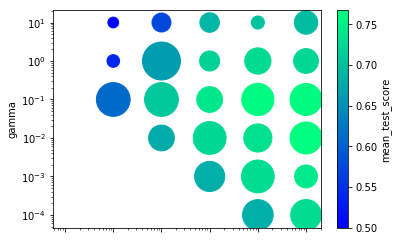

In [15]:
rbf10000 = rbf_df.xs(10000.0, level='max_iter').reset_index()
rbf10000.plot(kind='scatter', x='C', y='gamma', c='mean_test_score', s=rbf10000['std_test_score']*200000, cmap='winter', logx=True, logy=True)

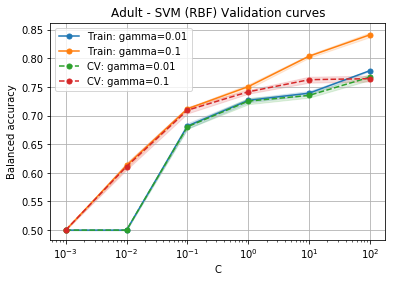

In [31]:
# Interesting cross sections above include gamma = 10^-1 and 10^-2
rbf_validation_curve1 = rbf_df.xs((10000.0, 0.01), level=('max_iter', 'gamma'))
rbf_validation_curve2 = rbf_df.xs((10000.0, 0.1), level=('max_iter', 'gamma'))
means = [rbf_validation_curve1['mean_train_score'], rbf_validation_curve2['mean_train_score'], rbf_validation_curve1['mean_test_score'], rbf_validation_curve2['mean_test_score']]
stds = [rbf_validation_curve1['std_train_score'], rbf_validation_curve2['std_train_score'], rbf_validation_curve1['std_test_score'], rbf_validation_curve2['std_test_score']]
labels = ['Train: gamma=0.01', 'Train: gamma=0.1', 'CV: gamma=0.01', 'CV: gamma=0.1']

plot_means_w_stds(means,stds,rbf_param_grid['C'], series_labels=labels, ylabel='Balanced accuracy', xlabel='C', logx=True, title='Adult - SVM (RBF) Validation curves', legend=True)


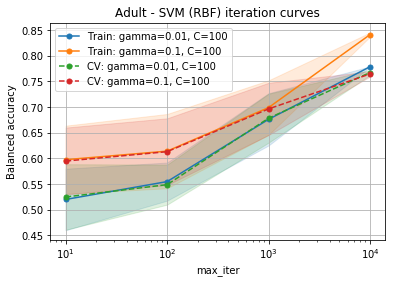

In [45]:
rbf_iter_curve1 = rbf_df.xs((100.0, 0.01), level=('C', 'gamma'))
rbf_iter_curve2 = rbf_df.xs((100.0, 0.1), level=('C', 'gamma'))
means = [rbf_iter_curve1['mean_train_score'], rbf_iter_curve2['mean_train_score'], rbf_iter_curve1['mean_test_score'], rbf_iter_curve2['mean_test_score']]
stds = [rbf_iter_curve1['std_train_score'], rbf_iter_curve2['std_train_score'], rbf_iter_curve1['std_test_score'], rbf_iter_curve2['std_test_score']]
labels = ['Train: gamma=0.01, C=100', 'Train: gamma=0.1, C=100', 'CV: gamma=0.01, C=100', 'CV: gamma=0.1, C=100']

plot_means_w_stds(means, stds, rbf_param_grid['max_iter'], series_labels=labels, ylabel='Balanced accuracy', xlabel='max_iter', logx=True, title='Adult - SVM (RBF) iteration curves', legend=True)

### Analysis (Linear)

In [36]:
# lin_res = linear_grid_search.cv_results_
lin_res = load_result_by_name('search_adult_SVM_0.764_2018-09-23_13-40-04-00_linear.pkl')
lin_df = scikit_cv_result_to_df(lin_res)

In [37]:
lin_df.sort_values(by='rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
C     max_iter                                                                 
1.0   100.0          0.535438      0.047894         0.073921        0.018905   
10.0  1000.0         2.294520      0.359350         0.017032        0.009131   
1.0   10000.0        0.839650      0.131776         0.048355        0.023063   
      1000.0         0.873401      0.124227         0.044856        0.025749   
0.1   10.0           0.152365      0.041419         0.024845        0.020598   
10.0  10000.0        3.809762      1.677735         0.004763        0.002907   
100.0 10000.0        9.995571      0.987146         0.004698        0.003403   
0.1   1000.0         0.183402      0.030207         0.071752        0.018407   
      100.0          0.226904      0.098289         0.047794        0.017078   
      10000.0        0.263137      0.047940         0.038553        0.037818   

                mean_test_score  std_test_score  rank_test_score  \
C     max_iter                                                     
1.0   100.0            0.764180        0.003662                1   
10.0  1000.0           0.763641        0.002890                2   
1.0   10000.0          0.763355        0.003251                3   
      1000.0           0.763355        0.003251                3   
0.1   10.0             0.762763        0.006103                5   
10.0  10000.0          0.762499        0.003269                6   
100.0 10000.0          0.762149        0.003238                7   
0.1   1000.0           0.758820        0.002676                8   
      100.0            0.758820        0.002676                8   
      10000.0          0.758820        0.002676                8   

                mean_train_score  std_train_score  
C     max_iter                                     
1.0   100.0             0.766892         0.000549  
10.0  1000.0            0.766818         0.001378  
1.0   10000.0           0.766119         0.001275  
      1000.0            0.766119         0.001275  
0.1   10.0              0.764907         0.005920  
10.0  10000.0           0.765961         0.001415  
100.0 10000.0           0.765568         0.002146  
0.1   1000.0            0.761176         0.001083  
      100.0             0.761176         0.001083  
      10000.0           0.761176         0.001083

Text(0.5,1,'Adult - Linear SVM CV scores')

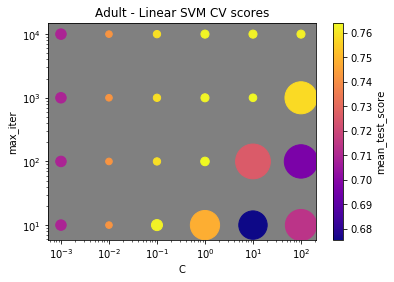

In [44]:
fig, ax = plt.subplots()
# lin_df = lin_df.reset_index()
lin_df.plot(ax=ax, kind='scatter', x='C', y='max_iter', c='mean_test_score', s=lin_df['std_test_score']*20000, cmap='plasma', logx=True, logy=True)
ax.set_facecolor('grey')
ax.set_title('Adult - Linear SVM CV scores')

In [17]:
# Helper function needed for std==0.0
def std_to_size(std):
    if std > 0:
        return std * 200000
    else:
        return 10

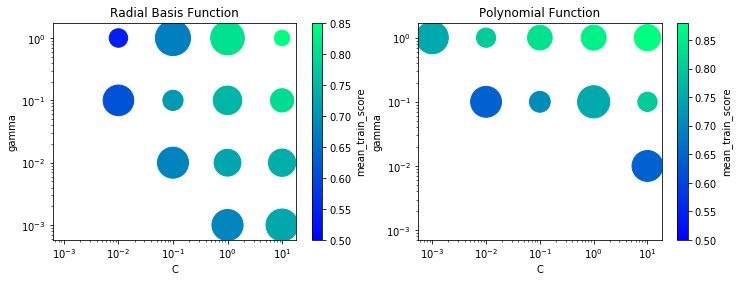

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=rbf['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=poly['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)

# ax3.set_title('Linear Function')
# lin.plot(kind='scatter', x='C', y='gamma', c='mean_train_score', s=lin['std_train_score'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax3)

### Timing statistics

In [19]:
# Helper function needed for std==0.0
def std_to_size(std):
    if std > 0:
        return std * 50
    else:
        return 10

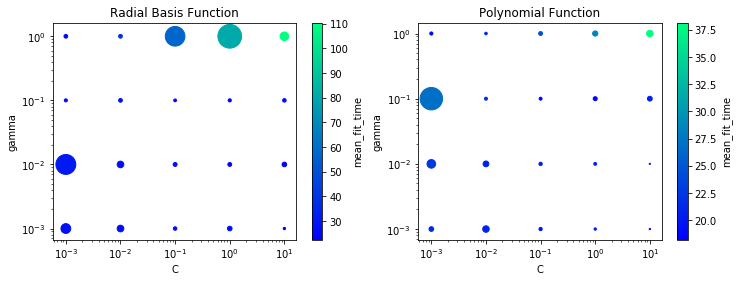

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.set_title('Radial Basis Function')
rbf.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=rbf['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax1)

ax2.set_title('Polynomial Function')
poly.plot(kind='scatter', x='C', y='gamma', c='mean_fit_time', s=poly['std_fit_time'].apply(std_to_size), cmap='winter', logx=True, logy=True, ax=ax2)

### What is the best estimator?

In [21]:
grid_search.best_estimator_.get_params()

NameError: name 'grid_search' is not defined

In [22]:
grid_search.best_score_

0.76287573694013378

## SVM Learning Curve Analysis

In [22]:
# Find best estimator
best_clf = rbf_grid_search.best_estimator_
best_clf.get_params()

{'C': 100.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': 10000.0,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data 

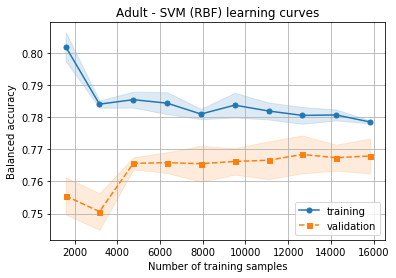

In [24]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(best_clf, X_train_scaled, y_train, scoring=balanced_accuracy_scorer, ylabel='Balanced accuracy', cv=4, n_jobs=-1, title='Adult - SVM (RBF) learning curves')

In [25]:
save_learning_curve(dataset, learner_type, train_sizes, train_mean, train_std, test_mean, test_std, extras='rbf')

# Test Set Performance

In [26]:
best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = balanced_accuracy(y_test, y_test_pred)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.7655


In [27]:
print('%.4f' % test_score)

0.7655
